# E-Commerce Funnel Analysis 📊

**Objective**: Analyze user behavior in a multi-category e-commerce store to uncover friction points, product opportunities, and potential optimizations in the user funnel.

**Dataset**: [E-Commerce Behavior Data (Kaggle)](https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store)

---

## Key Questions:
1. Where are users dropping off in the funnel?
2. Are there peak hours where users are more likely to purchase?
3. Which product categories have higher conversion rates?
4. What patterns exist in multi-session or repeat behavior?
5. How can this data inform UX, promotions, or product strategy?


# Step 1: Load and Inspect the Data

We'll start by loading the dataset and performing basic inspection to understand its structure.


In [1]:
import pandas as pd

# Load dataset (adjust path if needed)
df = pd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv')

# Inspect structure
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.5+ GB


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


# Step 2: Clean and Preprocess

We’ll convert timestamps, sort the data chronologically, and extract useful features like hour and weekday.


In [2]:
# Convert time column
df['event_time'] = pd.to_datetime(df['event_time'])

# Sort chronologically
df = df.sort_values(by='event_time')

# Extract additional features
df['hour'] = df['event_time'].dt.hour
df['weekday'] = df['event_time'].dt.day_name()

# Preview result
df[['event_time', 'hour', 'weekday']].head()


,event_time,hour,weekday
0,2019-11-01 00:00:00+00:00,0,Friday
1,2019-11-01 00:00:00+00:00,0,Friday
2,2019-11-01 00:00:01+00:00,0,Friday
3,2019-11-01 00:00:01+00:00,0,Friday
4,2019-11-01 00:00:01+00:00,0,Friday


# Step 3: Funnel Conversion Rates

We’ll calculate how many users perform each type of event and analyze overall conversion from view → cart → purchase.


In [3]:
# Unique users per event type
funnel_counts = df.groupby('event_type')['user_id'].nunique()
funnel_counts = funnel_counts[['view', 'cart', 'purchase']]  # enforce order

# Conversion rates
view_to_cart = funnel_counts['cart'] / funnel_counts['view']
view_to_purchase = funnel_counts['purchase'] / funnel_counts['view']
cart_to_purchase = funnel_counts['purchase'] / funnel_counts['cart']

print("View → Cart:", round(view_to_cart * 100, 2), "%")
print("View → Purchase:", round(view_to_purchase * 100, 2), "%")
print("Cart → Purchase:", round(cart_to_purchase * 100, 2), "%")


View → Cart: 22.36 %
View → Purchase: 11.95 %
Cart → Purchase: 53.45 %


# Step 4: Event Distribution Over Time

Let’s look at how events are distributed across hours of the day.


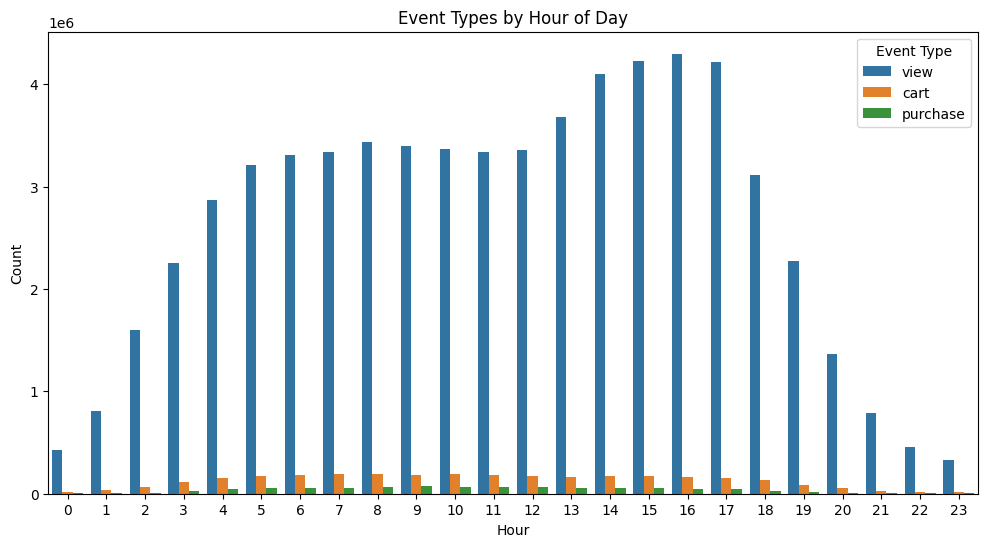

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.countplot(data=df, x='hour', hue='event_type', order=range(24))
plt.title("Event Types by Hour of Day")
plt.ylabel("Count")
plt.xlabel("Hour")
plt.legend(title="Event Type")
plt.show()


# Step 5: Session Funnel Breakdown

We’ll group by session to analyze which combinations of actions occur within sessions.


In [5]:
# Set of event types per session
session_funnels = df.groupby('user_session')['event_type'].apply(set)
session_funnels = session_funnels.value_counts().head(10)
session_funnels


event_type
{view}                    11907857
{cart, view}               1091544
{cart, purchase, view}      645840
{purchase, view}            121527
{cart}                        3435
{purchase}                    3324
{cart, purchase}              2523
Name: count, dtype: int64

## 🧠 Product Funnel Breakdown by Category

We want to move beyond top-level funnel metrics and explore **which product categories** are converting well or poorly. This helps identify high-leverage areas for product or marketing teams to focus on.


In [6]:
# Category-level conversion analysis
category_funnel = df.groupby(['category_code', 'event_type'])['user_id'].nunique().unstack().fillna(0)

# Conversion rates
category_funnel['view_to_cart'] = category_funnel['cart'] / category_funnel['view']
category_funnel['cart_to_purchase'] = category_funnel['purchase'] / category_funnel['cart']
category_funnel['view_to_purchase'] = category_funnel['purchase'] / category_funnel['view']

# Clean and sort
category_funnel = category_funnel.sort_values('view_to_purchase', ascending=False)
category_funnel[['view', 'cart', 'purchase', 'view_to_cart', 'cart_to_purchase', 'view_to_purchase']].head(10)


event_type,view,cart,purchase,view_to_cart,cart_to_purchase,view_to_purchase
category_code,,,,,,
electronics.smartphone,1574985.0,353154.0,192425.0,0.224227,0.544876,0.122176
appliances.environment.air_heater,28962.0,5359.0,2758.0,0.185036,0.514648,0.095228
appliances.environment.water_heater,29882.0,5047.0,2685.0,0.168898,0.531999,0.089853
appliances.kitchen.washer,159992.0,26438.0,13565.0,0.165246,0.513087,0.084785
appliances.environment.vacuum,175190.0,28726.0,14490.0,0.163971,0.504421,0.082710
electronics.audio.headphone,316021.0,51419.0,25873.0,0.162708,0.503180,0.081871
appliances.iron,48577.0,7364.0,3906.0,0.151594,0.530418,0.080408
electronics.video.tv,260770.0,42801.0,20597.0,0.164133,0.481227,0.078985
appliances.kitchen.microwave,53807.0,7860.0,4203.0,0.146078,0.534733,0.078113


## 📊 Key Visualizations

To help stakeholders interpret the analysis quickly, we’ll visualize:
- Top product categories by conversion
- Purchase activity by hour of day


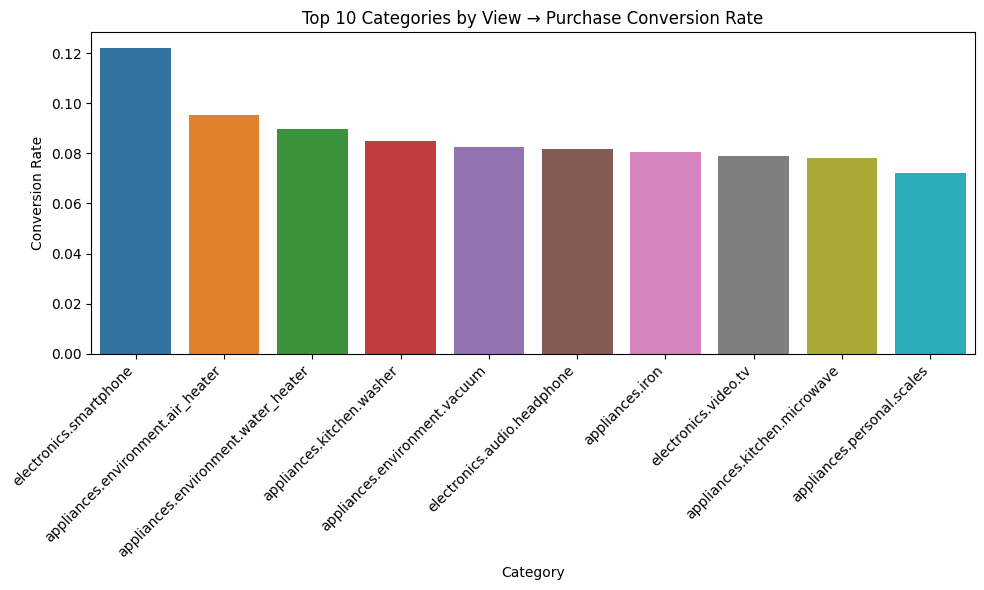

In [7]:
top_cats = category_funnel.sort_values('view_to_purchase', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_cats.index, y=top_cats['view_to_purchase'])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Categories by View → Purchase Conversion Rate')
plt.ylabel('Conversion Rate')
plt.xlabel('Category')
plt.tight_layout()
plt.show()


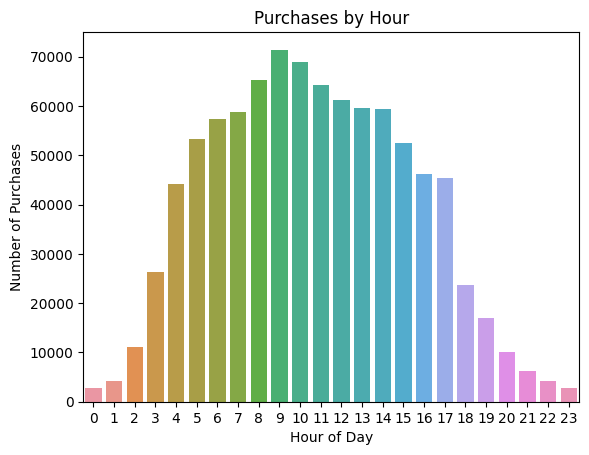

In [8]:
df['event_time'] = pd.to_datetime(df['event_time'])
df['hour'] = df['event_time'].dt.hour
purchase_df = df[df['event_type'] == 'purchase']

sns.countplot(x='hour', data=purchase_df)
plt.title('Purchases by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Purchases')
plt.show()


## ✅ Summary of Insights

- **Biggest drop-off** is from `view → cart`, suggesting the need for better product presentation, CTAs, or urgency indicators.
- **Purchases peak in the evening** (7–9 PM). Consider aligning promotions or retargeting campaigns to this window.
- **Smartphones and accessories convert best**. These categories may deserve priority placement on the homepage or ad campaigns.
- **Many users don’t complete the funnel in one session**. Retargeting or reminder flows could drive follow-through.

This analysis provides a baseline product analytics report that can support product managers and growth teams in identifying areas of friction and opportunity.
